In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
%matplotlib inline

from astropy.io import fits
import simcado

# Make a list of custom commands

In [2]:
cmd = simcado.UserCommands()
cmd["INST_FILTER_TC"] = "Ks"
cmd["FPA_LINEARITY_CURVE"] = None
cmd["OBS_DIT"] = 3600
cmd["OBS_REMOVE_CONST_BG"] = "yes"
cmd["FPA_CHIP_LAYOUT"] = "small"

# Read in 3 images and normalise them

In [19]:
blue = fits.getdata("antennae_blue.fits")
blue = (blue-7) / np.sum(blue)
red  = fits.getdata("antennae_red.fits")
red = (red-20) / np.sum(red)
ha   = fits.getdata("antennae_hydrogen.fits")
ha = (ha-23) / np.sum(ha)

# Make 3 spectra 
B0V for the young population,  
M0V for the old population and  
a single PaBeta emission line for the nebula emission

In [5]:
lam, r_spec = simcado.source.SED("M0V")
lam, b_spec = simcado.source.SED("B0V")
ha_spec = np.ones(len(lam)) * 1E-3
i = int((1.262 - lam.min()) / (lam[1] - lam[0]))
ha_spec[i] = 1

# Scale the spectra

In [6]:
lam, r_spec  = simcado.source.scale_spectrum(lam, r_spec, mag=17, filter_name="H")
lam, b_spec  = simcado.source.scale_spectrum(lam, b_spec, mag=17, filter_name="H")
lam, ha_spec = simcado.source.scale_spectrum(lam, ha_spec, mag=19, filter_name="H")

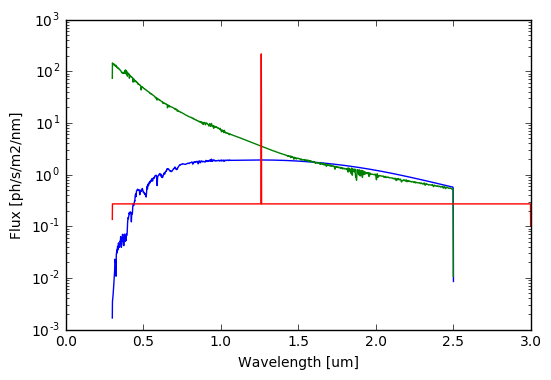

In [23]:
plt.plot(lam, r_spec, lam, b_spec, lam, ha_spec)
plt.semilogy(); plt.ylabel("Flux [ph/s/m2/nm]"); plt.xlabel("Wavelength [um]")

# Combine the images with the spectra

In [8]:
src_blue = simcado.source.source_from_image(images=blue, 
                                            lam=lam, spectra=b_spec, 
                                            plate_scale=0.004)
src_red  = simcado.source.source_from_image(images=red/np.sum(red), 
                                            lam=lam, spectra=r_spec, 
                                            plate_scale=0.004)
src_ha   = simcado.source.source_from_image(images=ha/np.sum(ha), 
                                            lam=lam, spectra=ha_spec, 
                                            plate_scale=0.004)

# Merge the 3 Source populations into 1 object

In [9]:
combi = src_blue + src_red + src_ha

## For fun, make 200 background stars between K=[20, 30]

In [10]:
n_bg_stars = 100

mags = np.random.normal(25, 3, n_bg_stars)
x, y = np.random.random((2, n_bg_stars))*4-2
spec_types = [(["A0V"]+["G2V"]*3+["M5V"]*7)[i] for i in np.random.randint(0, 10, n_bg_stars)]

bg_stars = simcado.source.stars(spec_types=spec_types, mags=mags, 
                                filter_name="H", x=x, y=y)

## Put in 15 background galaxies between K=[18, 24]

In [15]:
n_bg_gals = 15

x, y = np.random.random((2, n_bg_gals))*4-2
mags = np.random.normal(21, 3, n_bg_gals)
n    = np.random.random(n_bg_gals)*4+1
angle = np.random.random(n_bg_gals)*180
ellip = np.random.random(n_bg_gals)
gal_type = [simcado.source.get_SED_names()[4:7][i] for i in np.random.randint(0, 3, n_bg_gals)]

bg_galaxies = simcado.source.empty_sky()
for i in range(n_bg_gals):
    gal = simcado.source.galaxy(1E9, 1E3, plate_scale=0.004, 
                                magnitude=mags[i], n=n[i],
                                angle=angle[i], ellipticity=ellip[i], 
                                spectrum=gal_type[i],
                                width=2, height=2)
    gal.shift(x[i], y[i])
    bg_galaxies += gal
    if i%3 == 0: print(i+1)

1
4
7
10
13


# Combine the main galaxy with the background sources

In [16]:
all_spark = bg_galaxies + combi + bg_stars

In [17]:
print(np.max((all_spark).photons_in_range(1, 2.5)))

6836.66685514


# simcado.run!

In [18]:
all_spark = bg_galaxies + combi + bg_stars
cmd["INST_FILTER_TC"] = "Ks"
hdu = simcado.run(all_spark, cmds=cmd, filename="ant_Ks.fits")

all_spark = bg_galaxies + combi + bg_stars
cmd["INST_FILTER_TC"] = "J"
hdu = simcado.run(all_spark, cmds=cmd, filename="ant_J.fits")

all_spark = bg_galaxies + combi + bg_stars
cmd["INST_FILTER_TC"] = "PaBeta"
hdu = simcado.run(all_spark, cmds=cmd, filename="ant_PaBeta.fits")

Detector layout
 id x_cen y_cen x_len y_len gain
--- ----- ----- ----- ----- ----
  0     0     0  1024  1024  1.0
Creating 1 layer(s) per chip
1 chip(s) will be simulated
Generating image for chip 0
Reading out chip 0
Detector layout
 id x_cen y_cen x_len y_len gain
--- ----- ----- ----- ----- ----
  0     0     0  1024  1024  1.0
Creating 1 layer(s) per chip
1 chip(s) will be simulated
Generating image for chip 0
Reading out chip 0
Detector layout
 id x_cen y_cen x_len y_len gain
--- ----- ----- ----- ----- ----
  0     0     0  1024  1024  1.0
Creating 5 layer(s) per chip
1 chip(s) will be simulated
Generating image for chip 0
Reading out chip 0
